[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/FairSense/blob/main/docs/notebooks/demo-classification.ipynb)

## Demo: Fairness on classification problems

In [1]:
# !pip install -e fairsense

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deel.fairsense.data_management.factory import from_numpy, from_pandas
from deel.fairsense.data_management.processing import one_hot_encode
from deel.fairsense.indices.confidence_intervals import with_confidence_intervals
from deel.fairsense.indices.cvm import cvm_indices
from deel.fairsense.indices.standard_metrics import disparate_impact
from deel.fairsense.indices.sobol import sobol_indices
from deel.fairsense.utils.dataclasses import IndicesInput
from deel.fairsense.utils.fairness_objective import y_true, squared_error, y_pred, classification_error
from deel.fairsense.visualization.plots import cat_plot
from deel.fairsense.visualization.text import format_with_intervals
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## 1 study of the intrinsic fairness of the dataset

### data wrangling
in this notebook we will work on the adult dataset.

In [3]:
data = pd.read_csv("data/adult.csv")
data["income"] = data["income"] == ">50K"
data = data.drop(['native-country', 'fnlwgt'], axis=1)
# data = data[data["native-country"] != "Holand-Netherlands"]
data.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,False
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,False
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,True
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,True
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,False


### indice computation: Disparate impact

First we will start with computing some indices on the training data to see if the dataset is biased.
The first step consist of building the IndicesInput object that stores the data. As we can set the target `y_true` means that we analyse the data, but this can be set to `y_pred` if we want to analyse predictions, or `squared_error` if we want to analyse the error.
We can then apply preprocessing such as one_hot encoding.

In [4]:
indices_inputs = from_pandas(data, "income", target=y_true)
categorical_cols = list(filter(lambda col: data.dtypes[col] == "O", data.columns))
indices_inputs = one_hot_encode(indices_inputs, categorical_cols)

We then declare the indices computation functions. The results are stored in a `indicesOuput` object. raw value can be acessed with `.values`, note that 0 refers to total independence and 1 refers to total dependence.

In [5]:
indices_outputs = disparate_impact(indices_inputs)
indices_outputs.values

,DI
age,NaN
capital-gain,NaN
capital-loss,NaN
education,0.591701
educational-num,NaN
gender,0.640345
hours-per-week,NaN
marital-status,0.682576
occupation,0.439293
race,0.380506


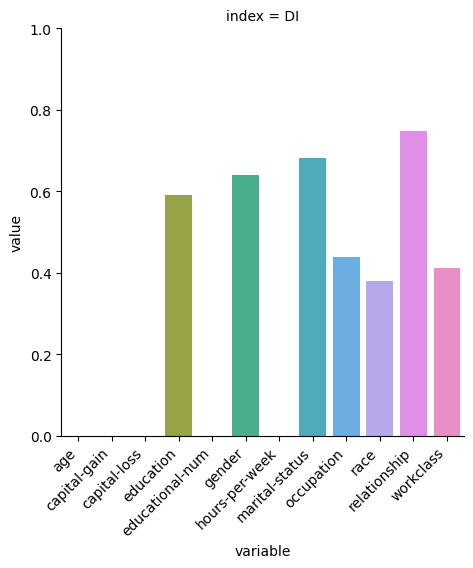

In [6]:
cat_plot(indices_outputs, plot_per="index", kind="bar")
plt.show()

It is also possible to decorate any indice function with `with_confidence_intervals` to use bootstrapping to compute confidence intervals. We can also use the + operator to compute multiple indices simulteanously. Results with confidence intervals can be visualized either textually with `format_with_intervals` or 'graphically with `cat_plot`

In [7]:
di_with_ci = with_confidence_intervals(n_splits=30)(disparate_impact)
indices_outputs = di_with_ci(indices_inputs)
format_with_intervals(indices_outputs, quantile=0.05)

100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 13.05it/s]


,DI
age,"nan [nan, nan]"
capital-gain,"nan [nan, nan]"
capital-loss,"nan [nan, nan]"
education,"0.60 [0.54, 0.65]"
educational-num,"nan [nan, nan]"
gender,"0.64 [0.58, 0.71]"
hours-per-week,"nan [nan, nan]"
marital-status,"0.73 [0.54, 0.84]"
occupation,"0.46 [0.40, 0.53]"
race,"0.42 [0.26, 0.56]"


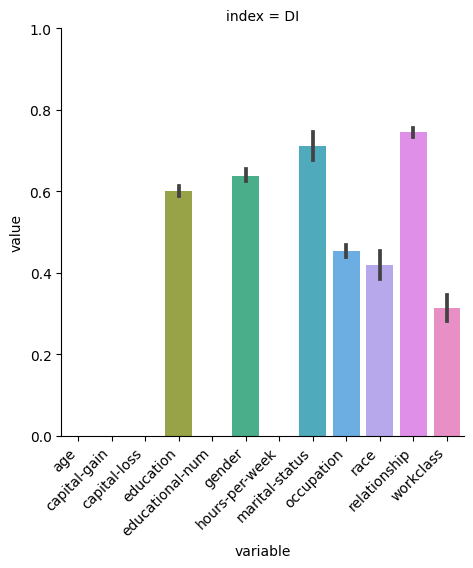

In [8]:
cat_plot(indices_outputs, plot_per="index", kind="bar")
plt.show()

## 2 train a model and analyse it's sensitivity

first we will split the data and then train a basic model on it.

In [9]:
data = data.sample(frac=1.) # shuffle data
data_train = data.iloc[:int(len(data)*0.8)]
data_test = data.iloc[int(len(data)*0.8):]

similarly we build the `IndiceInput` object

In [10]:
indices_inputs_train = IndicesInput(
    x=indices_inputs.x.iloc[:int(len(data)*0.8)], 
    y_true=indices_inputs.y_true.iloc[:int(len(data)*0.8)], 
    variable_groups=indices_inputs.variable_groups
)
indices_inputs_test = IndicesInput(
    x=indices_inputs.x.iloc[int(len(data)*0.8):], 
    y_true=indices_inputs.y_true.iloc[int(len(data)*0.8):], 
    variable_groups=indices_inputs.variable_groups
)

then we train a basic model: DecisionTree. Note that this analysis can be applied to any callable that can handle numpy array as inputs.

In [11]:
model = DecisionTreeClassifier()
model.fit(indices_inputs_train.x, indices_inputs_train.y_true)
train_acc = accuracy_score(indices_inputs_train.y_true, model.predict(indices_inputs_train.x))
val_acc = accuracy_score(indices_inputs_test.y_true, model.predict(indices_inputs_test.x))
print(f"train acc: {train_acc}, val acc {val_acc}")

train acc: 0.9718987536150283, val acc 0.8322243832531477


we set the model and the objective

In [12]:
indices_inputs_train.model = model.predict
indices_inputs_train.objective = y_pred
indices_inputs_test.model = model.predict
indices_inputs_test.objective = y_pred
indices_inputs.model = model.predict
indices_inputs.objective = y_pred

In [13]:
cvm_with_ci = with_confidence_intervals(n_splits=30)(cvm_indices)
di_with_ci = with_confidence_intervals(n_splits=30)(disparate_impact)
sobol_with_ci = with_confidence_intervals(n_splits=30)(sobol_indices)
indices_outputs_test = cvm_with_ci(indices_inputs_train) + di_with_ci(indices_inputs_train)# + sobol_with_ci(indices_inputs_train)
format_with_intervals(indices_outputs_test, quantile=0.1)

100%|███████████████████████████████████████████| 30/30 [00:02<00:00, 14.54it/s]


,CVM,CVM_indep,DI
age,"0.00 [0.00, 0.00]","0.24 [0.20, 0.29]","nan [nan, nan]"
capital-gain,"0.00 [0.00, 0.00]","0.01 [0.00, 0.02]","nan [nan, nan]"
capital-loss,"0.00 [0.00, 0.00]","0.00 [0.00, 0.02]","nan [nan, nan]"
education,"0.00 [0.00, 0.00]","0.01 [0.00, 0.04]","0.61 [0.56, 0.66]"
educational-num,"0.00 [0.00, 0.00]","0.05 [0.03, 0.07]","nan [nan, nan]"
gender,"0.00 [0.00, 0.00]","0.01 [0.00, 0.02]","0.62 [0.55, 0.69]"
hours-per-week,"0.00 [0.00, 0.00]","0.09 [0.05, 0.12]","nan [nan, nan]"
marital-status,"0.00 [0.00, 0.00]","0.01 [0.00, 0.03]","0.68 [0.57, 0.80]"
occupation,"0.00 [0.00, 0.00]","0.02 [0.00, 0.04]","0.47 [0.44, 0.55]"
race,"0.00 [0.00, 0.00]","0.00 [0.00, 0.02]","0.40 [0.30, 0.57]"


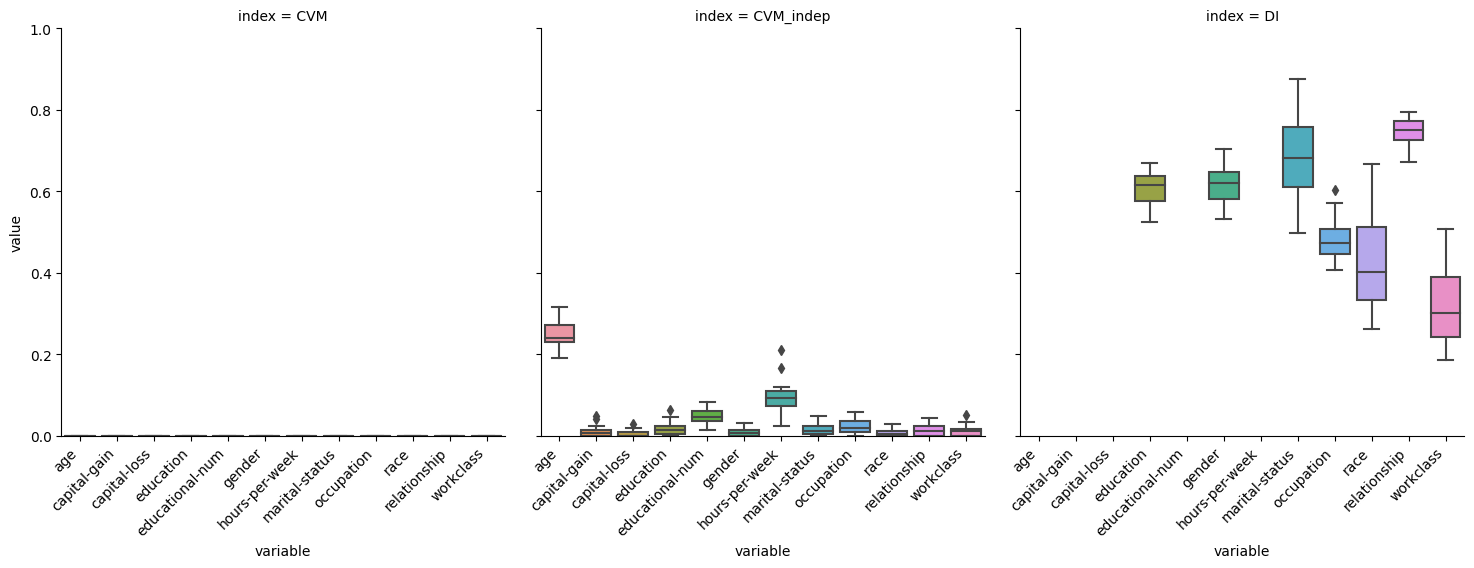

In [14]:
cat_plot(indices_outputs_test, plot_per="index", kind="box", col_wrap=3)
plt.show()

In [15]:
indices_inputs_train._objective = classification_error
indices_inputs_test._objective = classification_error

In [16]:
cvm_with_ci = with_confidence_intervals(n_splits=15)(cvm_indices)
sobol_with_ci = with_confidence_intervals(n_splits=15)(sobol_indices)
indices_outputs_test_error = cvm_with_ci(indices_inputs_test)# + sobol_with_ci(indices_inputs_test)
format_with_intervals(indices_outputs_test_error, quantile=0.1)

100%|███████████████████████████████████████████| 15/15 [00:13<00:00,  1.09it/s]


,CVM,CVM_indep
age,"0.00 [0.00, 0.00]","0.21 [0.18, 0.27]"
capital-gain,"0.00 [0.00, 0.00]","0.00 [0.00, 0.01]"
capital-loss,"0.00 [0.00, 0.00]","0.00 [0.00, 0.02]"
education,"0.00 [0.00, 0.00]","0.02 [0.00, 0.04]"
educational-num,"0.00 [0.00, 0.00]","0.05 [0.03, 0.07]"
gender,"0.00 [0.00, 0.00]","0.00 [0.00, 0.02]"
hours-per-week,"0.00 [0.00, 0.00]","0.09 [0.02, 0.13]"
marital-status,"0.00 [0.00, 0.00]","0.01 [0.00, 0.03]"
occupation,"0.00 [0.00, 0.00]","0.01 [0.00, 0.04]"
race,"0.00 [0.00, 0.00]","0.00 [0.00, 0.02]"


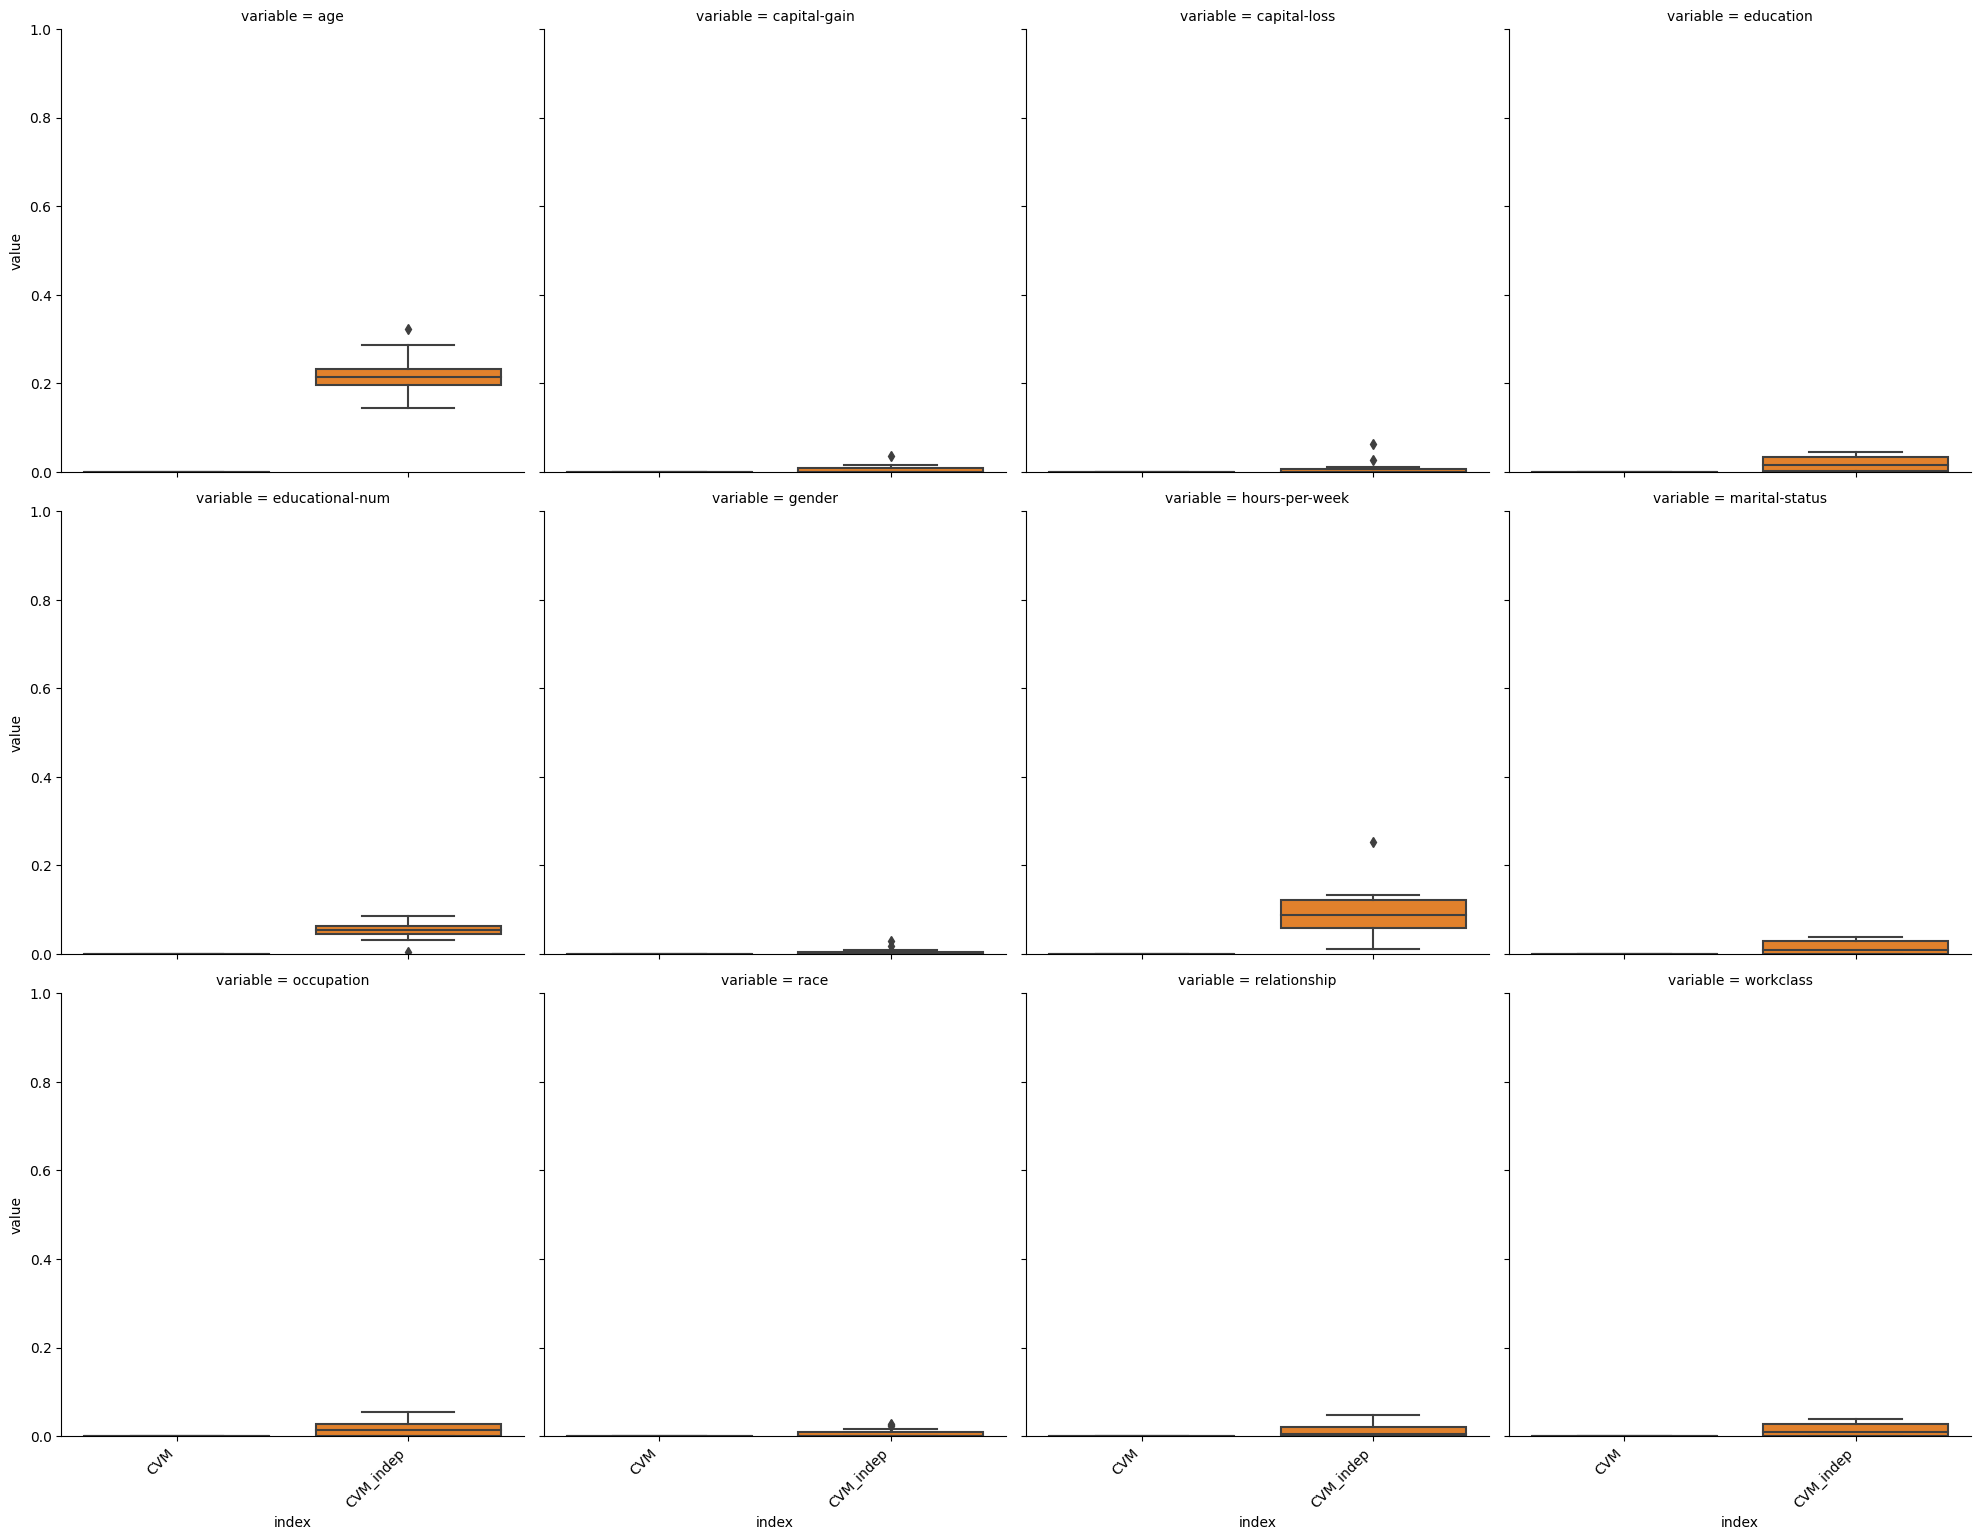

In [17]:
cat_plot(indices_outputs_test_error, plot_per="variable", kind="box", col_wrap=4)
plt.show()